WIP

In [1]:
import warnings
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from statsmodels.stats.weightstats import DescrStatsW
from econml.dml import LinearDML
from econml.grf import CausalForest
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
df = pd.read_csv("Nutrition__Physical_Activity__and_Obesity_-_Behavioral_Risk_Factor_Surveillance_System.csv")

### Preparation

In [3]:
obesity_df = df[df['Class'] == 'Obesity / Weight Status']
obesity_threshold = obesity_df['Data_Value'].quantile(0.85)
obesity_df = obesity_df[obesity_df['Data_Value'] > obesity_threshold]

physical_activity_df = df[df['Class'] == 'Physical Activity']
physical_activity_threshold = physical_activity_df['Data_Value'].quantile(0.85)
physical_activity_df = physical_activity_df[physical_activity_df['Data_Value'] > physical_activity_threshold]

combined_df = pd.concat([obesity_df, physical_activity_df])

factors = ['Age(years)', 'Education', 'Gender', 'Income', 'Race/Ethnicity', 'LocationDesc']
X = combined_df[factors]

combined_df['Treatment'] = (combined_df['Class'] == 'Obesity / Weight Status').astype(int)
y = combined_df['Data_Value']


### Propensity scores 
probability of being in the "obesity" group

In [4]:
X_encoded = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, combined_df['Treatment'], test_size=0.2, random_state=42)
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
combined_df['Propensity_Score'] = log_reg.predict_proba(X_encoded)[:, 1] 

In [5]:
coefficients = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Coefficient': log_reg.coef_[0]
})

coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
top_features = coefficients.sort_values(by='Abs_Coefficient', ascending=False).head(10)
print("Top features PS:")
print(top_features)

Top features PS:
                                         Feature  Coefficient  Abs_Coefficient
17      Race/Ethnicity_Hawaiian/Pacific Islander     2.133268         2.133268
19             Race/Ethnicity_Non-Hispanic Black     1.987134         1.987134
8                                    Gender_Male     1.909795         1.909795
18                       Race/Ethnicity_Hispanic     1.776420         1.776420
29             LocationDesc_District of Columbia    -1.679234         1.679234
2                             Age(years)_45 - 54     1.626220         1.626220
15  Race/Ethnicity_American Indian/Alaska Native     1.572476         1.572476
13                      Income_Data not reported    -1.568421         1.568421
33                           LocationDesc_Hawaii    -1.544326         1.544326
3                             Age(years)_55 - 64     1.489374         1.489374


In [6]:
y_pred = log_reg.predict(X_test)

print("PS confusion matrix")
confusion_matrix(y_test, y_pred)

PS confusion matrix


array([[1139,  326],
       [ 518,  554]])

In [7]:
print("PS classification report")
print(classification_report(y_test, y_pred))

PS classification report
              precision    recall  f1-score   support

           0       0.69      0.78      0.73      1465
           1       0.63      0.52      0.57      1072

    accuracy                           0.67      2537
   macro avg       0.66      0.65      0.65      2537
weighted avg       0.66      0.67      0.66      2537



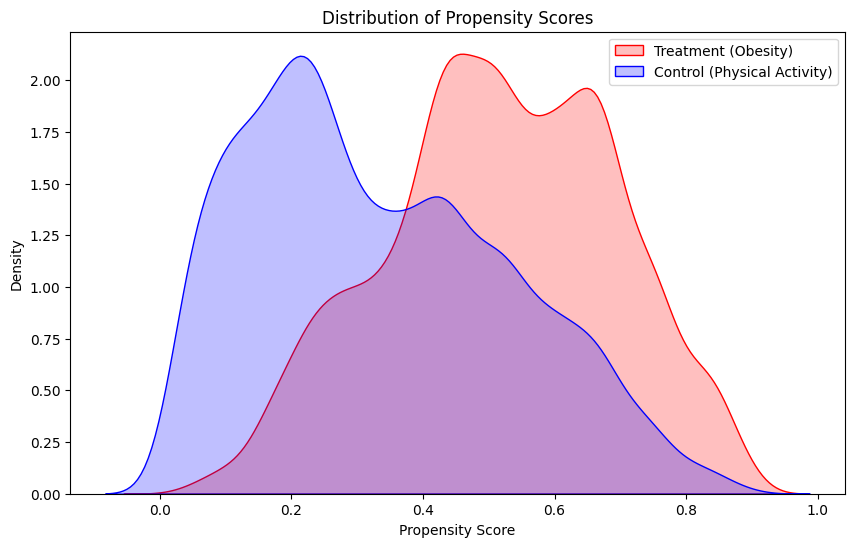

In [8]:
plt.figure(figsize=(10, 6))
sns.kdeplot(combined_df.loc[combined_df['Treatment'] == 1, 'Propensity_Score'], color='red', label='Treatment (Obesity)', shade=True)
sns.kdeplot(combined_df.loc[combined_df['Treatment'] == 0, 'Propensity_Score'], color='blue', label='Control (Physical Activity)', shade=True)
plt.title('Distribution of Propensity Scores')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.show()

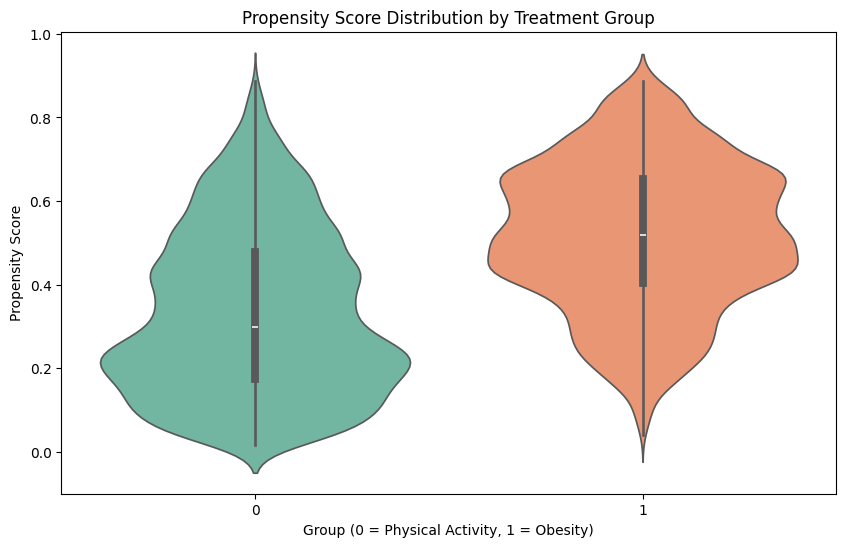

In [9]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Treatment', y='Propensity_Score', data=combined_df, palette="Set2")
plt.title('Propensity Score Distribution by Treatment Group')
plt.xlabel('Group (0 = Physical Activity, 1 = Obesity)')
plt.ylabel('Propensity Score')
plt.show()


Causal Analysis

In [10]:
combined_df['IPW'] = combined_df['Treatment'] / combined_df['Propensity_Score'] \
        + (1 - combined_df['Treatment']) / (1 - combined_df['Propensity_Score'])

treatment_effect = combined_df.loc[combined_df['Treatment'] == 1, 'Data_Value'].mean() \
                 - combined_df.loc[combined_df['Treatment'] == 0, 'Data_Value'].mean()

print(f"Unadjusted Treatment Effect (Difference in Means): {treatment_effect:.4f}")

Unadjusted Treatment Effect (Difference in Means): -12.2809


In [11]:
weighted_stats = DescrStatsW(combined_df['Data_Value'], weights=combined_df['IPW'], ddof=0)
ate_ipw = weighted_stats.mean
print(f"IPW-Weighted Average Treatment Effect (ATE): {ate_ipw:.4f}")

IPW-Weighted Average Treatment Effect (ATE): 47.3211


In [12]:
X = pd.get_dummies(combined_df[factors], drop_first=True)
y = combined_df['Data_Value']
treatment = combined_df['Treatment']


dml = LinearDML(model_y=RandomForestRegressor(n_estimators=100, random_state=42), 
                model_t=RandomForestRegressor(n_estimators=100, random_state=42),
                random_state=42)

dml.fit(Y=y, T=treatment, X=X)
treatment_effects = dml.effect(X)

ate_dml = dml.ate(X)
print(f"DML Average Treatment Effect (ATE): {ate_dml:.4f}")

DML Average Treatment Effect (ATE): -12.0835


In [13]:
ate_dml = dml.ate(X)
ate_dml_ci = dml.ate_interval(X, alpha=0.05) 

print(f"Average Treatment Effect (ATE): {ate_dml:.4f}")
print(f"95% Confidence Interval for ATE: ({ate_dml_ci[0]:.4f}, {ate_dml_ci[1]:.4f})")


Average Treatment Effect (ATE): -12.0835
95% Confidence Interval for ATE: (-12.2575, -11.9096)


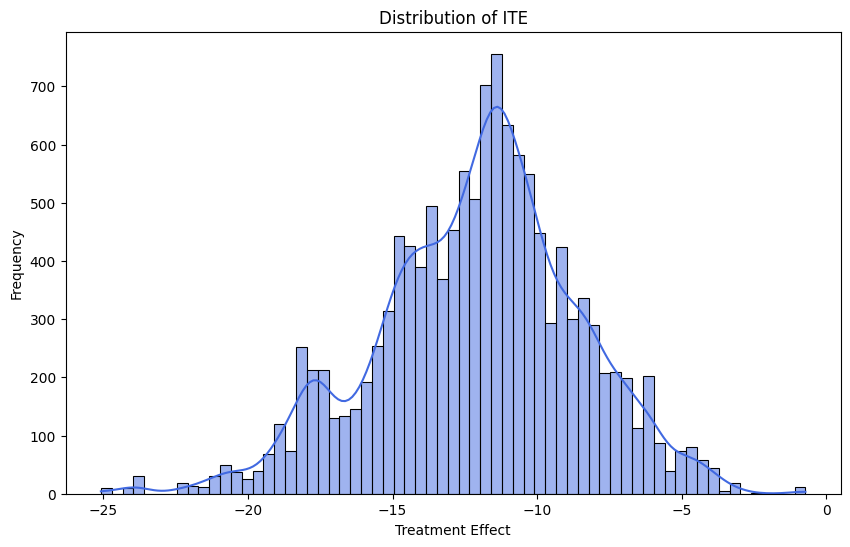

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(treatment_effects, kde=True, color='royalblue')
plt.title('Distribution of ITE')
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.show()

In [15]:
coef_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': dml.coef_
})

coef_importance_sorted = coef_importance.sort_values(by='Coefficient', ascending=False)

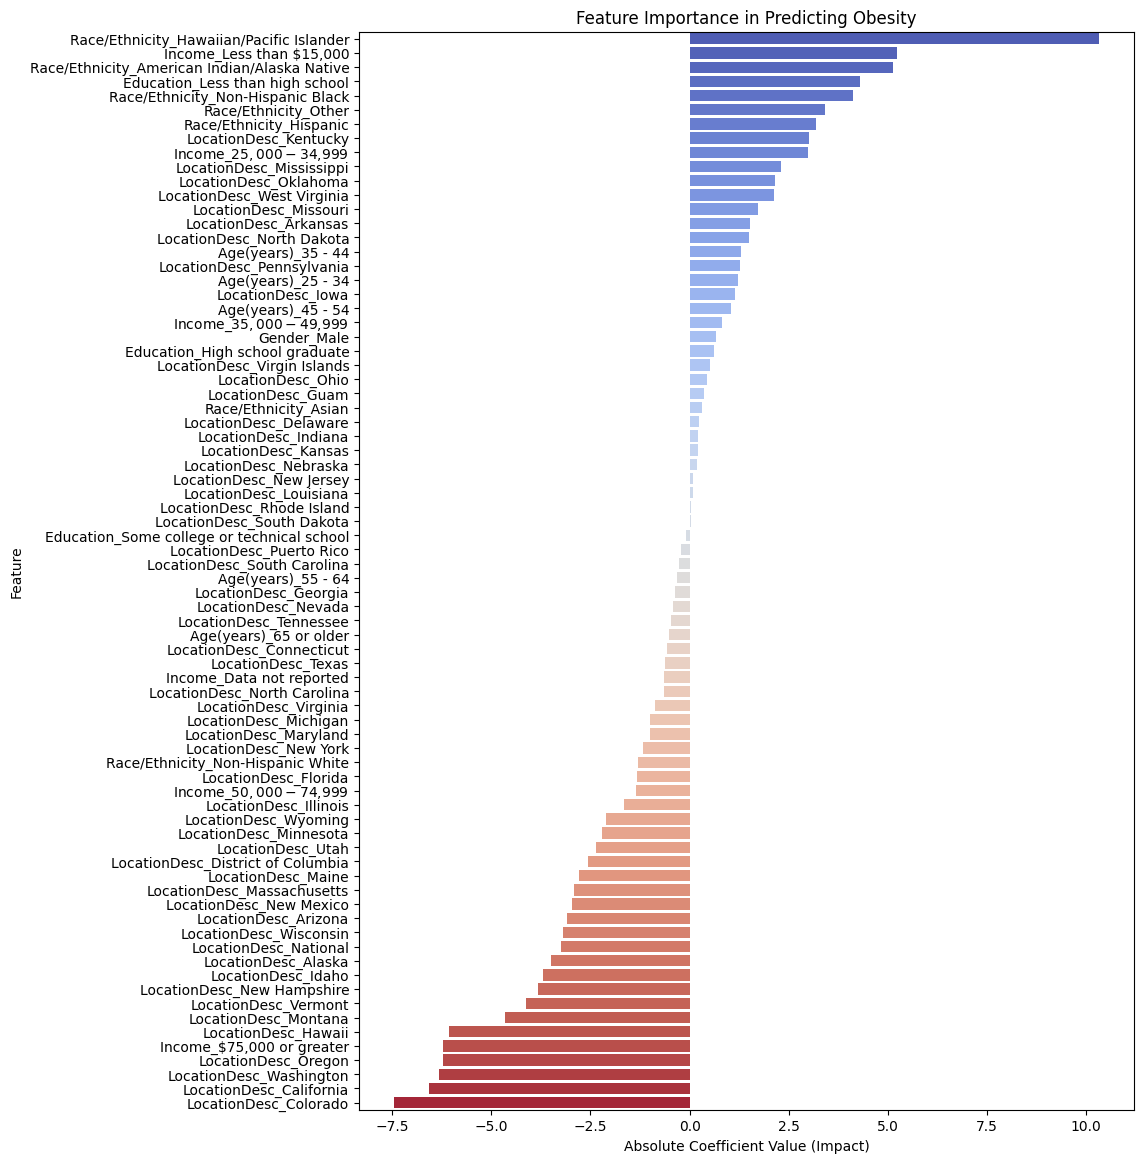

In [16]:
plt.figure(figsize=(10, 14))
sns.barplot(x='Coefficient', y='Feature', data=coef_importance_sorted, palette='coolwarm')
plt.title('Feature Importance in Predicting Obesity')
plt.xlabel('Absolute Coefficient Value (Impact)')
plt.ylabel('Feature')
plt.show()